<a href="https://colab.research.google.com/github/Nedu21/Keras-deep-learning-projects/blob/main/TransferLearningForCustomImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning For Custom Images
Keras makes it incredibly easy to use state-of-the-art image models through its keras.applications module.
Popular Models:
- VGG16 / VGG19: They have a very simple and deep architecture. They are a bit older and heavier (large file size) but are still great for learning and for many tasks.
- ResNet50 (and its variants): This model was revolutionary because it introduced "residual connections" (or shortcuts) that allowed it to be much deeper than VGG without losing performance. It's a fantastic all-around performer and a very common choice for transfer learning.
- InceptionV3: Developed by Google, this model is clever about being both accurate and computationally efficient. It uses special "inception modules" that process the image at different scales simultaneously.
- MobileNet: As the name suggests, this model is designed to be lightweight and fast, making it perfect for mobile devices and applications where speed is critical. It sacrifices a tiny bit of accuracy for a huge gain in efficiency.

## Make necessary imports

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Conv2D
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomWidth, RandomHeight, RandomZoom, Rescaling, Resizing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.keras.optimizers import Adam

## Preprocess the data

In [2]:
# Load the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (48000, 28, 28) - y_train shape: (48000,)
x_val shape: (12000, 28, 28) - y_val shape: (12000,)
x_test shape: (10000, 28, 28) - y_test shape: (10000,)


Convert the target variable into binary categories using keras to_categorical function

In [3]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [4]:
# Get the number of classes for the output layer
num_classes = y_train.shape[1]

### Perform data augmentation

In [5]:
# Define the data augmentation layers as a sequential model
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.055),
    RandomZoom(0.2),
    RandomWidth(0.1),
    RandomHeight(0.2),
])

# Define the rescaling layer
rescaling = Rescaling(1./255)

# Image size
IMG_SIZE = 224
resizing = Resizing(IMG_SIZE, IMG_SIZE)

In [6]:
BATCH_SIZE = 32
# Create Dataset objects from the training, validation, and test data
train_ds = Dataset.from_tensor_slices((x_train, y_train))
val_ds = Dataset.from_tensor_slices((x_val, y_val))
test_ds = Dataset.from_tensor_slices((x_test, y_test))

# Training pipeline: shuffle, batch, apply augmentation and rescale
train_ds = train_ds.shuffle(train_ds.cardinality()) # .cardinality results in a uniform shuffle.
train_ds = train_ds.batch(BATCH_SIZE)

train_ds = train_ds.map(lambda x, y: (tf.expand_dims(x, axis=-1), y))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training =True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (resizing(x), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (rescaling(x), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

# Validation and Test Pipelines: Just batch and rescale. No shuffling or augmentation!
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.map(lambda x, y: (tf.expand_dims(x, axis=-1), y)) # <-- Add it here too
val_ds = val_ds.map(lambda x, y: (resizing(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (rescaling(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.map(lambda x, y: (tf.expand_dims(x, axis=-1), y)) # <-- And here as well
test_ds = test_ds.map(lambda x, y: (resizing(x), y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (rescaling(x), y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

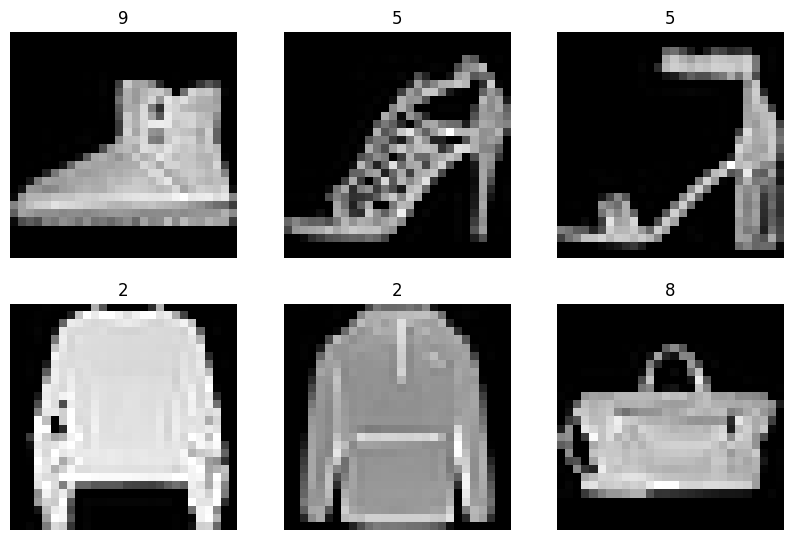

In [7]:
# Plot image samples
plt.figure(figsize=(10, 10))
for i in range(6):
  plt.subplot(3, 3, i+1)
  plt.imshow(x_train[i], cmap='gray')
  plt.title(np.argmax(y_train[i]))
  plt.axis('off')
plt.show()

## Model Building

In [8]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
# Freeze the Base Model
base_model.trainable = False

In [9]:
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 1)) # Start with the original image shape
x = Conv2D(3, 3, padding='same', activation='relu')(inputs) # Add a Conv2D layer to expand to 3 channels
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Create and compile the final model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,608,232 (90.06 MB)

 Trainable params: 20,520 (80.16 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Feature Extraction

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 311s 194ms/step - accuracy: 0.3632 - loss: 1.7358 - val_accuracy: 0.6514 - val_loss: 1.1165
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 288s 192ms/step - accuracy: 0.7276 - loss: 0.7499 - val_accuracy: 0.7042 - val_loss: 0.9763
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 288s 192ms/step - accuracy: 0.7620 - loss: 0.6511 - val_accuracy: 0.7404 - val_loss: 0.8759
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 287s 191ms/step - accuracy: 0.7766 - loss: 0.6161 - val_accuracy: 0.7639 - val_loss: 0.7642
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 288s 192ms/step - accuracy: 0.7900 - loss: 0.5771 - val_accuracy: 0.7755 - val_loss: 0.7253
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 288s 192ms/step - accuracy: 0.7982 - loss: 0.5533 - val_accuracy: 0.8093 - val_loss: 0.5859
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 288s 192ms/step - accuracy: 0.8039 - loss: 0.5333 - val_accuracy: 0.8033 - val_loss: 0.6573
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 287s 191ms/step - ac

In [12]:
# Get the best epoch based on validation loss (due to EarlyStopping)
best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))

# Get the corresponding metrics for the best epoch
best_train_loss = history.history['loss'][best_epoch]
best_train_accuracy = history.history['accuracy'][best_epoch]
best_val_loss = history.history['val_loss'][best_epoch]
best_val_accuracy = history.history['val_accuracy'][best_epoch]

print(f"Best Epoch: {best_epoch + 1}") # Add 1 because epochs are 0-indexed
print(f"Best Training Loss: {best_train_loss:.4f}")
print(f"Best Training Accuracy: {best_train_accuracy:.4f}")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

Best Epoch: 6
Best Training Loss: 0.5496
Best Training Accuracy: 0.7991
Best Validation Loss: 0.5859
Best Validation Accuracy: 0.8093


### Fine-tuning the model

In [27]:
# Unfreeze the Base Model
base_model.trainable = True

# A switch to control which layers to freeze
fine_tune = False

# i is set to get the number of the layer
i = 0

# Loop through all layers in the base model
for layer in base_model.layers:
  i += 1

  # Once we hit the target block, we start fine-tuning
  if layer.name == 'conv5_block1_1_conv': # A specific layer at the start of conv5
    fine_tune = True

  # If the switch is on, the layer is trainable
  if fine_tune:
    layer.trainable = True
  # Otherwise, keep the layer frozen
  else:
    layer.trainable = False

  # --- VERIFICATION STEP ---
  # Print the layer's name and its status
  print(f"{i} {layer.name}: Trainable = {layer.trainable}")

1 input_layer_1: Trainable = False
2 conv1_pad: Trainable = False
3 conv1_conv: Trainable = False
4 conv1_bn: Trainable = False
5 conv1_relu: Trainable = False
6 pool1_pad: Trainable = False
7 pool1_pool: Trainable = False
8 conv2_block1_1_conv: Trainable = False
9 conv2_block1_1_bn: Trainable = False
10 conv2_block1_1_relu: Trainable = False
11 conv2_block1_2_conv: Trainable = False
12 conv2_block1_2_bn: Trainable = False
13 conv2_block1_2_relu: Trainable = False
14 conv2_block1_0_conv: Trainable = False
15 conv2_block1_3_conv: Trainable = False
16 conv2_block1_0_bn: Trainable = False
17 conv2_block1_3_bn: Trainable = False
18 conv2_block1_add: Trainable = False
19 conv2_block1_out: Trainable = False
20 conv2_block2_1_conv: Trainable = False
21 conv2_block2_1_bn: Trainable = False
22 conv2_block2_1_relu: Trainable = False
23 conv2_block2_2_conv: Trainable = False
24 conv2_block2_2_bn: Trainable = False
25 conv2_block2_2_relu: Trainable = False
26 conv2_block2_3_conv: Trainable = False

In [30]:
# Re-compile with a tiny learning rate
model.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [31]:
# Get the last epoch from fine-tuning the model
last_epoch = len(history.epoch)

# --- Fine-Tuning Training ---
# Use the 'last_epoch' variable for your initial_epoch
fine_tune_epochs = 11
total_epochs = last_epoch + fine_tune_epochs

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=last_epoch, # You're telling Keras to start counting from where the last training session stopped
    callbacks=[early_stopping]
)

Epoch 10/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 356s 224ms/step - accuracy: 0.7417 - loss: 1.1950 - val_accuracy: 0.7953 - val_loss: 0.8107
Epoch 11/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 332s 221ms/step - accuracy: 0.8221 - loss: 0.5426 - val_accuracy: 0.8183 - val_loss: 0.6016
Epoch 12/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 382s 221ms/step - accuracy: 0.8472 - loss: 0.4408 - val_accuracy: 0.8317 - val_loss: 0.5325
Epoch 13/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 331s 221ms/step - accuracy: 0.8569 - loss: 0.4010 - val_accuracy: 0.8492 - val_loss: 0.4634
Epoch 14/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 331s 221ms/step - accuracy: 0.8666 - loss: 0.3717 - val_accuracy: 0.8580 - val_loss: 0.4187
Epoch 15/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 331s 221ms/step - accuracy: 0.8736 - loss: 0.3486 - val_accuracy: 0.8657 - val_loss: 0.3969
Epoch 16/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 331s 221ms/step - accuracy: 0.8796 - loss: 0.3282 - val_accuracy: 0.8647 - val_loss: 0.3928
Epoch 17/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 331s 221ms/s

In [33]:
# Get the index of the best epoch within the fine-tuning history based on validation loss
best_epoch_index_in_finetune_history = history.history['val_loss'].index(min(history.history['val_loss']))

# The actual best epoch number is the initial_epoch of fine-tuning plus the index
best_epoch_absolute = last_epoch + best_epoch_index_in_finetune_history

# Get the corresponding metrics for the best epoch (using the index in fine-tune history)
best_train_loss = history.history['loss'][best_epoch_index_in_finetune_history]
best_train_accuracy = history.history['accuracy'][best_epoch_index_in_finetune_history]
best_val_loss = history.history['val_loss'][best_epoch_index_in_finetune_history]
best_val_accuracy = history.history['val_accuracy'][best_epoch_index_in_finetune_history]

# Print the best metrics
print(f"Best Epoch (based on validation loss): {best_epoch_absolute + 1}") # Add 1 because epochs are 0-indexed internally
print(f"Best Training Loss: {best_train_loss:.4f}")
print(f"Best Training Accuracy: {best_train_accuracy:.4f}")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

Best Epoch (based on validation loss): 19
Best Training Loss: 0.2839
Best Training Accuracy: 0.8963
Best Validation Loss: 0.3641
Best Validation Accuracy: 0.8713


### Making predictions on the test set

In [34]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_ds)

print(f"Final Test Loss: {loss:.4f}")
print(f"Final Test Accuracy: {accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.8702 - loss: 0.3852
Final Test Loss: 0.3760
Final Test Accuracy: 0.8698


## Plotting train/val loss and acc to understand what happened

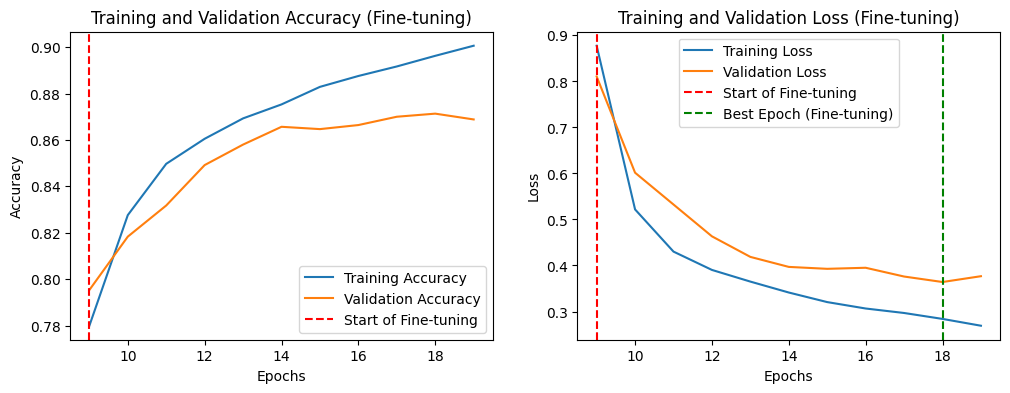

In [36]:
hist = history.history
epochs = range(last_epoch, last_epoch + len(hist['accuracy'])) # Create epoch numbers starting from last_epoch

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, hist['accuracy'], label='Training Accuracy') # Use epochs for x-axis
plt.plot(epochs, hist['val_accuracy'], label='Validation Accuracy') # Use epochs for x-axis
plt.axvline(last_epoch, color='red', linestyle='--', label='Start of Fine-tuning') # Add a line for the start of fine-tuning
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Fine-tuning)')

plt.subplot(1, 2, 2)
plt.plot(epochs, hist['loss'], label='Training Loss') # Use epochs for x-axis
plt.plot(epochs, hist['val_loss'], label='Validation Loss') # Use epochs for x-axis
plt.axvline(last_epoch, color='red', linestyle='--', label='Start of Fine-tuning') # Add a line for the start of fine-tuning
plt.axvline(best_epoch_absolute, color='green', linestyle='--', label='Best Epoch (Fine-tuning)') # Add a line for the best epoch in fine-tuning
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Fine-tuning)')

plt.show()